In [1]:
import numpy as np
import argparse
import time
from itertools import chain
import matplotlib.pyplot as plt
import multiprocessing as mp
import os
import sys

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR
import configs

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
save_path = '../trained_models/01_loss_curves/'
iter_dirs = os.listdir(save_path)

device = 'cpu'

kernels = []

net = STDP_SR(num_states=16, gamma=0.4)
for iter_dir in iter_dirs:
    iter_path = save_path + iter_dir + '/'
    for file in os.listdir(iter_path):
        if 'tfevents' not in file: continue
        tfevents_path = iter_path + file
        event_acc = EventAccumulator(tfevents_path)
        event_acc.Reload()
        scalar_events = event_acc.Scalars('loss_train')
        final_loss_train = scalar_events[-1].value
        break
    if final_loss_train > 1E-3: continue
    model_path = iter_path + '/model.pt'
    net.load_state_dict(torch.load(model_path))
    kernels.append(net.ca3.get_stdp_kernel(kernel_len=7))

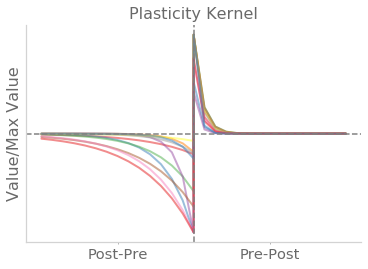

In [6]:
plt.figure()
for (xs, ys) in kernels[:20]:
    plt.plot(xs, ys/np.max(np.abs(ys)), alpha=0.5, linewidth=2)
plt.xticks([])
plt.axvline(0, linestyle='--', color="gray")
plt.axhline(0, linestyle='--', color="gray")
plt.title("Plasticity Kernel")
plt.ylabel("Value/Max Value")
plt.xticks([-3.5, 3.5], ['Post-Pre', 'Pre-Post'])
plt.yticks([])
plt.ylim(-1.1, 1.1)
plt.savefig('kernels.png', dpi=300)
plt.show()

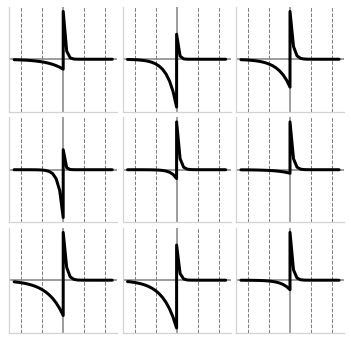

In [5]:
import matplotlib.gridspec as gridspec

grid_x = 3; grid_y = 3;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

for idx in range(min(len(kernels), grid_x*grid_y)):
    xs, ys = kernels[idx]
    ax = plt.subplot(gs1[idx])
    ax.axvline(0, color="gray")
    ax.axhline(0, color="gray")
    ax.axvline(-3, linestyle='--', linewidth=1, color="gray")
    ax.axvline(3, linestyle='--', linewidth=1, color="gray")
    ax.axvline(-6, linestyle='--', linewidth=1, color="gray")
    ax.axvline(6, linestyle='--', linewidth=1, color="gray")
    ax.plot(
        xs, ys/np.max(np.abs(ys)),
        linewidth=3, color='black'
        )
    plt.axis('on')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(-1.1, 1.1)
plt.savefig('kernels_grid.png', dpi=300)
plt.show()